In [3]:
import librosa
import numpy as np
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import wave
import struct
from scipy.fftpack import dct as scipy_dct
sc = StandardScaler()

In [4]:
FRAME_SIZE = 400   
FRAME_SHIFT = 160    
PRE_EMPHASIS = 0.97
NUM_FILTERS = 39    
NUM_MFCC = 39

#### Extract MFCC

In [5]:
def pre_emphasize(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def framing(signal, frame_size, frame_shift):
    num_frames = (len(signal) - frame_size) // frame_shift + 1
    frames = np.zeros((num_frames, frame_size))
    for i in range(num_frames):
        start = i * frame_shift
        frames[i] = signal[start:start + frame_size]
    return frames

def hamming_window(frames):
    num_samples = frames.shape[1]
    n = np.arange(num_samples)
    window = 0.54 - 0.46 * np.cos(2 * np.pi * n / (num_samples - 1))

    return frames * window

def fft(frames):
    fft_size = frames.shape[1]
    magnitude_spectrum = np.abs(np.fft.rfft(frames, n=fft_size))
    power_spectrum = (1.0 / fft_size) * (magnitude_spectrum ** 2)
    return power_spectrum


def mel_filter_bank(num_filters, fft_size, sample_rate):
    mel_min = 0
    mel_max = 2595 * np.log10(1 + (sample_rate / 2) / 700)
    mel_points = np.linspace(mel_min, mel_max, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)

    filters = np.zeros((num_filters, fft_size // 2 + 1))
    for i in range(1, num_filters + 1):
        filters[i - 1, bin_points[i - 1]:bin_points[i]] = np.linspace(0, 1, bin_points[i] - bin_points[i - 1])
        filters[i - 1, bin_points[i]:bin_points[i + 1]] = np.linspace(1, 0, bin_points[i + 1] - bin_points[i])
    return filters


def apply_filter_bank(power_spectrum, filters):
    return np.dot(power_spectrum, filters.T)

def log_compression(energy):
    return np.log(energy + 1e-10)

def DCT(data):
    return scipy_dct(data,type=2,norm='ortho')[:,:20]

In [6]:
def feat_extraction(signal):
    
    signal = pre_emphasize(signal)
    frames = framing(signal, FRAME_SIZE, FRAME_SHIFT)
    frames = hamming_window(frames)
    power_spectrum = fft(frames)
    filters = mel_filter_bank(NUM_FILTERS, FRAME_SIZE, 16000)
    mel_energy = apply_filter_bank(power_spectrum, filters)
    log_energy = log_compression(mel_energy)
    mfcc = DCT(log_energy)

    fixed_frames = 500
    if mfcc.shape[0] < fixed_frames:
        mfcc_padded = np.pad(mfcc, ((0, fixed_frames - mfcc.shape[0]),(0,0)), mode='constant')
    else:
        mfcc_padded = mfcc[:fixed_frames,:]
    mfccs = feat_sclaing(mfcc_padded)

    return mfccs

In [7]:
def read_wave(file_path):
    with wave.open(file_path, 'r') as wav_file:
        n_frames = wav_file.getnframes()
        audio_data = wav_file.readframes(n_frames)
        audio_signal = struct.unpack("<" + str(n_frames) + "h", audio_data)
        sample_rate = wav_file.getframerate()
    return np.array(audio_signal, dtype=np.float32), sample_rate

In [8]:
def feat_sclaing(x):
    out = sc.fit_transform(x)
    return out

In [9]:
path = '/kaggle/input/language-speech/IIIT Spoken Language Datasets'
files = os.listdir(path)

In [10]:
files

['Tamil', 'Hindi', 'Bengali', 'Kannada', 'Telgu', 'Marathi', 'Malayalam']

In [11]:
data = []
for i in range(len(files)):
    for j in os.listdir(path+'/'+files[i])[:900]:
        data.append([path+'/'+files[i]+'/'+j,i])

In [12]:
data = np.array(data)
df = pd.DataFrame(data,columns=['Data','Class'])
df.head()

,Data,Class
0,/kaggle/input/language-speech/IIIT Spoken Lang...,0
1,/kaggle/input/language-speech/IIIT Spoken Lang...,0
2,/kaggle/input/language-speech/IIIT Spoken Lang...,0
3,/kaggle/input/language-speech/IIIT Spoken Lang...,0
4,/kaggle/input/language-speech/IIIT Spoken Lang...,0


#### Average Duration: 5.716948095238103 
Max Duration: 16.0792 
Min Duration: 2.2574375

In [13]:
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

In [14]:
df.head()

,Data,Class
0,/kaggle/input/language-speech/IIIT Spoken Lang...,2
1,/kaggle/input/language-speech/IIIT Spoken Lang...,0
2,/kaggle/input/language-speech/IIIT Spoken Lang...,1
3,/kaggle/input/language-speech/IIIT Spoken Lang...,5
4,/kaggle/input/language-speech/IIIT Spoken Lang...,0


In [15]:
x = df['Data'].values
y_train = df['Class'].values

In [16]:
feat = []
for i in x:
    signal, sample_rate = read_wave(i)
    ft = feat_extraction(signal)
    feat.append(ft)

In [17]:
feat_tdnn = np.array(feat)

In [18]:
feat_nn = np.sum(feat,axis=2)

In [19]:
feat_nn.shape

(6300, 500)

In [20]:
featDf = pd.DataFrame(feat_nn)

In [21]:
featDf['Class'] = df['Class']

In [22]:
featDf.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,Class
0,13.551285,11.003430,14.212264,9.181021,12.173312,10.614084,6.169935,8.951554,5.586785,7.860406,...,3.618054,3.618054,3.618054,3.618054,3.618054,3.618054,3.618054,3.618054,3.618054,2
1,7.765118,9.893959,8.462994,7.955187,8.482766,10.000114,2.378574,-2.582333,3.569720,2.556717,...,11.815953,12.604627,7.068896,5.570388,5.062405,8.534950,2.707289,5.516650,-2.910238,0
2,3.294441,5.476785,2.938890,2.099709,5.476005,-2.010941,-4.559658,-0.084398,-3.323262,-1.560911,...,-6.486338,-4.531573,-11.984684,-7.574482,-4.972209,-7.253004,-2.645635,-2.212651,-4.858698,1
3,2.259243,12.441656,2.583373,3.246279,8.159517,7.626244,3.023858,1.805124,10.435204,5.064216,...,-5.045079,-9.983459,-4.584597,-3.125531,-4.825629,-4.362103,1.172183,-7.357079,-6.874294,5
4,4.901408,-0.899052,2.738501,0.116635,2.475711,6.218609,3.925164,-7.010911,4.791241,5.463293,...,5.425366,5.425366,5.425366,5.425366,5.425366,5.425366,5.425366,5.425366,5.425366,0


In [23]:
csv_file = featDf.to_csv('out.csv')

In [24]:
df['Class'] = df['Class'].astype('int')

In [25]:
x_train = featDf.iloc[:,:13].values
y_train = df['Class'].values[:len(featDf)]

In [26]:
y_train = y_train.reshape((len(featDf),))

In [27]:
x_train.shape

(6300, 13)

### Naive approach

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [27]:
model = Sequential()
model.add(Dense(1024,activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='sigmoid'))

In [28]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [29]:
history = model.fit(x_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2146 - loss: 1.8543
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2504 - loss: 1.7408
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2951 - loss: 1.6775
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3249 - loss: 1.6382
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3430 - loss: 1.5934
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3715 - loss: 1.5625
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3834 - loss: 1.5202
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3968 - loss: 1.5014
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4033 - loss: 1.4705
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4125 - loss: 1.4258
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4455 - loss: 1.3808
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy:

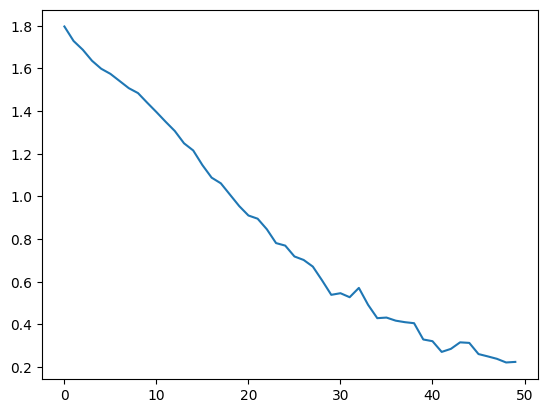

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

#### TDNN handling temporal info

In [31]:
feat_tdnn.shape

(6300, 500, 20)

In [32]:
x_train = feat_tdnn

In [33]:
y_train = df['Class'].values
y_train.shape

(6300,)

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalAveragePooling1D, Lambda, Flatten,Concatenate,GlobalMaxPooling1D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [35]:
def tdnn_layer(inputs, units, context):
    context_range = max(context) - min(context) + 1
    dilation_rate = abs(context[1] - context[0])
    return Conv1D(filters=units, kernel_size=context_range, dilation_rate=dilation_rate, activation='relu', padding='valid')(inputs)


In [36]:
inputs = Input(shape=(500, 20))

# TDNN Layers
x = tdnn_layer(inputs, 128, [-2, -1, 0, 1, 2])
x = Dropout(0.2)(x)
x = tdnn_layer(x, 128, [-2, 0, 2])
x = Dropout(0.2)(x)
x = tdnn_layer(x, 128, [-3, 0, 3])
x = Dropout(0.2)(x)

# Flatten the output of the last TDNN layer
x = Flatten()(x)  # Convert (batch_size, time_steps, features) -> (batch_size, time_steps * features)

# Fully Connected Layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(7, activation='softmax')(x)

# Define the model
model = Model(inputs, outputs)

In [37]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 500, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 496, 128)       │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 496, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 488, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 488, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 470, 128)       │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 470, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 60160)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │    15,401,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,644,807 (59.68 MB)

 Trainable params: 15,644,807 (59.68 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.fit(x_train, y_train,epochs=5)

Epoch 1/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 95s 473ms/step - accuracy: 0.4591 - loss: 1.3796
Epoch 2/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 90s 457ms/step - accuracy: 0.9631 - loss: 0.1231
Epoch 3/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 142s 457ms/step - accuracy: 0.9860 - loss: 0.0462
Epoch 4/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 90s 458ms/step - accuracy: 0.9956 - loss: 0.0174
Epoch 5/5
197/197 ━━━━━━━━━━━━━━━━━━━━ 92s 465ms/step - accuracy: 0.9947 - loss: 0.0169


In [28]:
featDf['Class'] = featDf['Class'].astype(int)

In [29]:
featDf['Class']

0       2
1       0
2       1
3       5
4       0
       ..
6295    4
6296    5
6297    5
6298    5
6299    0
Name: Class, Length: 6300, dtype: int64

In [30]:
featDf = np.array(featDf)
m,n = featDf.shape

In [31]:
featDf

array([[13.55128469, 11.00343036, 14.21226366, ...,  3.61805424,
         3.61805424,  2.        ],
       [ 7.76511767,  9.89395936,  8.46299384, ...,  5.51665019,
        -2.91023842,  0.        ],
       [ 3.29444055,  5.47678524,  2.93888971, ..., -2.21265137,
        -4.85869832,  1.        ],
       ...,
       [ 8.4694502 ,  5.17945123,  8.28284765, ...,  1.75269487,
         0.38041727,  5.        ],
       [10.36599953, 12.59108767,  7.93454835, ...,  2.05726657,
        -0.57651283,  5.        ],
       [ 2.82503921,  4.14399221,  4.9771556 , ..., 11.82335682,
         9.34226464,  0.        ]])

In [32]:
n

501

In [33]:
dd = featDf.T
y = dd[500]
x = dd[0:n-1]

In [34]:
y = y.astype(int)

### Scratch neural network

In [35]:
def generate():
    w1 = 0.1*np.random.randn(128,500)
    b1 = 0.1*np.random.randn(128,1)
    w2 = 0.1*np.random.randn(7,128)
    b2 = 0.1*np.random.randn(7,1)
    return w1,b1,w2,b2

import numpy as np

def sigmoid(z):
    return np.where(
        z >= 0,
        1 / (1 + np.exp(-z)),
        np.exp(z) / (1 + np.exp(z))
    )

def forward(w1,b1,w2,b2,x):
    z1 = w1.dot(x)+b1
    a1 = sigmoid(z1)
    z2 = w2.dot(a1)+b2
    a2 = sigmoid(z2)
    return z1,a1,z2,a2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def der(z):
    return sigmoid(z)*(1-sigmoid(z))
    
def back(z1,a1,z2,a2,w1,w2,x,y):
    one_y = one_hot(y)
    er = a2 - one_y
    #error in outer layer
    delt = er * der(z2)
    dw2 = 1 / m *delt.dot(a1.T)
    db2 = 1 / m * np.sum(er)
    #error in hidden layer
    delt_hid = w2.T.dot(delt) * der(z1)
    dw1 = 1 / m * delt_hid.dot(x.T)
    db1 = 1 / m * np.sum(delt_hid)
    
    return dw1,db1,dw2,db2

def update(w1,b1,w2,b2,dw1,db1,dw2,db2,a):
    w1 = w1 - a*dw1
    b1 = b1 - a *db1
    w2 = w2 - a*dw2
    b2 = b2 - a *db2
    return w1,b1,w2,b2
    

In [36]:
def get_predictions(a2):
    return np.argmax(a2, 0)

def get_accuracy(predictions, y):
    print(predictions, y)
    return np.sum(predictions == y) / y.size

def gradient(x,y,a,it):
    w1,b1,w2,b2 = generate()
    for i in range(it):
        z1,a1,z2,a2 = forward(w1,b1,w2,b2,x)
        dw1,db1,dw2,db2 = back(z1,a1,z2,a2,w1,w2,x,y)
        w1,b1,w2,b2 = update(w1,b1,w2,b2,dw1,db1,dw2,db2,a)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(a2)
            print(get_accuracy(predictions, y))
    return w1, b1, w2, b2

In [37]:
w1,b1,w2,b2= gradient(x, y, 0.8,1000)

Iteration:  0
[6 4 6 ... 0 0 4] [2 0 1 ... 5 5 0]
0.14396825396825397
Iteration:  10
[6 4 2 ... 0 0 4] [2 0 1 ... 5 5 0]
0.2019047619047619
Iteration:  20
[4 4 1 ... 0 0 4] [2 0 1 ... 5 5 0]
0.29825396825396827
Iteration:  30
[4 4 1 ... 0 0 4] [2 0 1 ... 5 5 0]
0.36603174603174604
Iteration:  40
[4 0 1 ... 6 0 4] [2 0 1 ... 5 5 0]
0.4023809523809524
Iteration:  50
[4 0 1 ... 6 0 4] [2 0 1 ... 5 5 0]
0.43253968253968256
Iteration:  60
[4 0 1 ... 2 0 4] [2 0 1 ... 5 5 0]
0.4579365079365079
Iteration:  70
[4 0 1 ... 2 0 4] [2 0 1 ... 5 5 0]
0.4785714285714286
Iteration:  80
[4 0 1 ... 2 0 4] [2 0 1 ... 5 5 0]
0.5
Iteration:  90
[4 0 1 ... 2 0 4] [2 0 1 ... 5 5 0]
0.5165079365079365
Iteration:  100
[4 0 1 ... 2 0 4] [2 0 1 ... 5 5 0]
0.5293650793650794
Iteration:  110
[4 0 1 ... 2 0 2] [2 0 1 ... 5 5 0]
0.5436507936507936
Iteration:  120
[4 0 1 ... 2 0 6] [2 0 1 ... 5 5 0]
0.5576190476190476
Iteration:  130
[4 0 1 ... 2 0 6] [2 0 1 ... 5 5 0]
0.5701587301587302
Iteration:  140
[4 0 1 ... 2